In [ ]:
# Import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Data

df = pd.read_csv('https://raw.githubusercontent.com/renatomaaliw3/public_files/refs/heads/master/Data%20Sets/daily_revenue.csv', index_col = 'date', parse_dates = True, dayfirst = True)
df.head(3)

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%


In [ ]:
# Data Processing

df['revenue'] = df['revenue'].str.replace(",", "").astype(float)
df = df.asfreq('D')
df.head(3)

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27%,1.09%
2018-01-02,8922076.0,30.87%,1.08%
2018-01-03,8446101.0,28.11%,1.01%


In [ ]:
# Data Processing

df['discount_rate'] = df['discount_rate'].str.replace("%", "").astype(float)
df['coupon_rate'] = df['coupon_rate'].str.replace("%", "").astype(float)
df.head(3)

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27,1.09
2018-01-02,8922076.0,30.87,1.08
2018-01-03,8446101.0,28.11,1.01


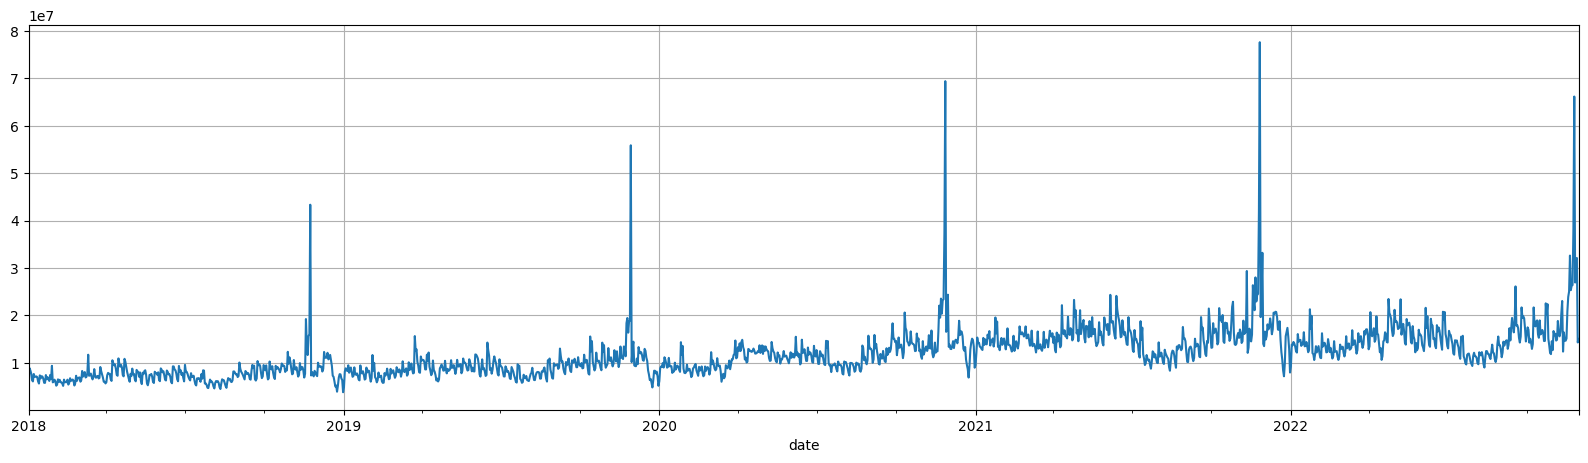

In [ ]:
# Plot

df['revenue'].plot(figsize = (20, 5), grid = True)
plt.show()

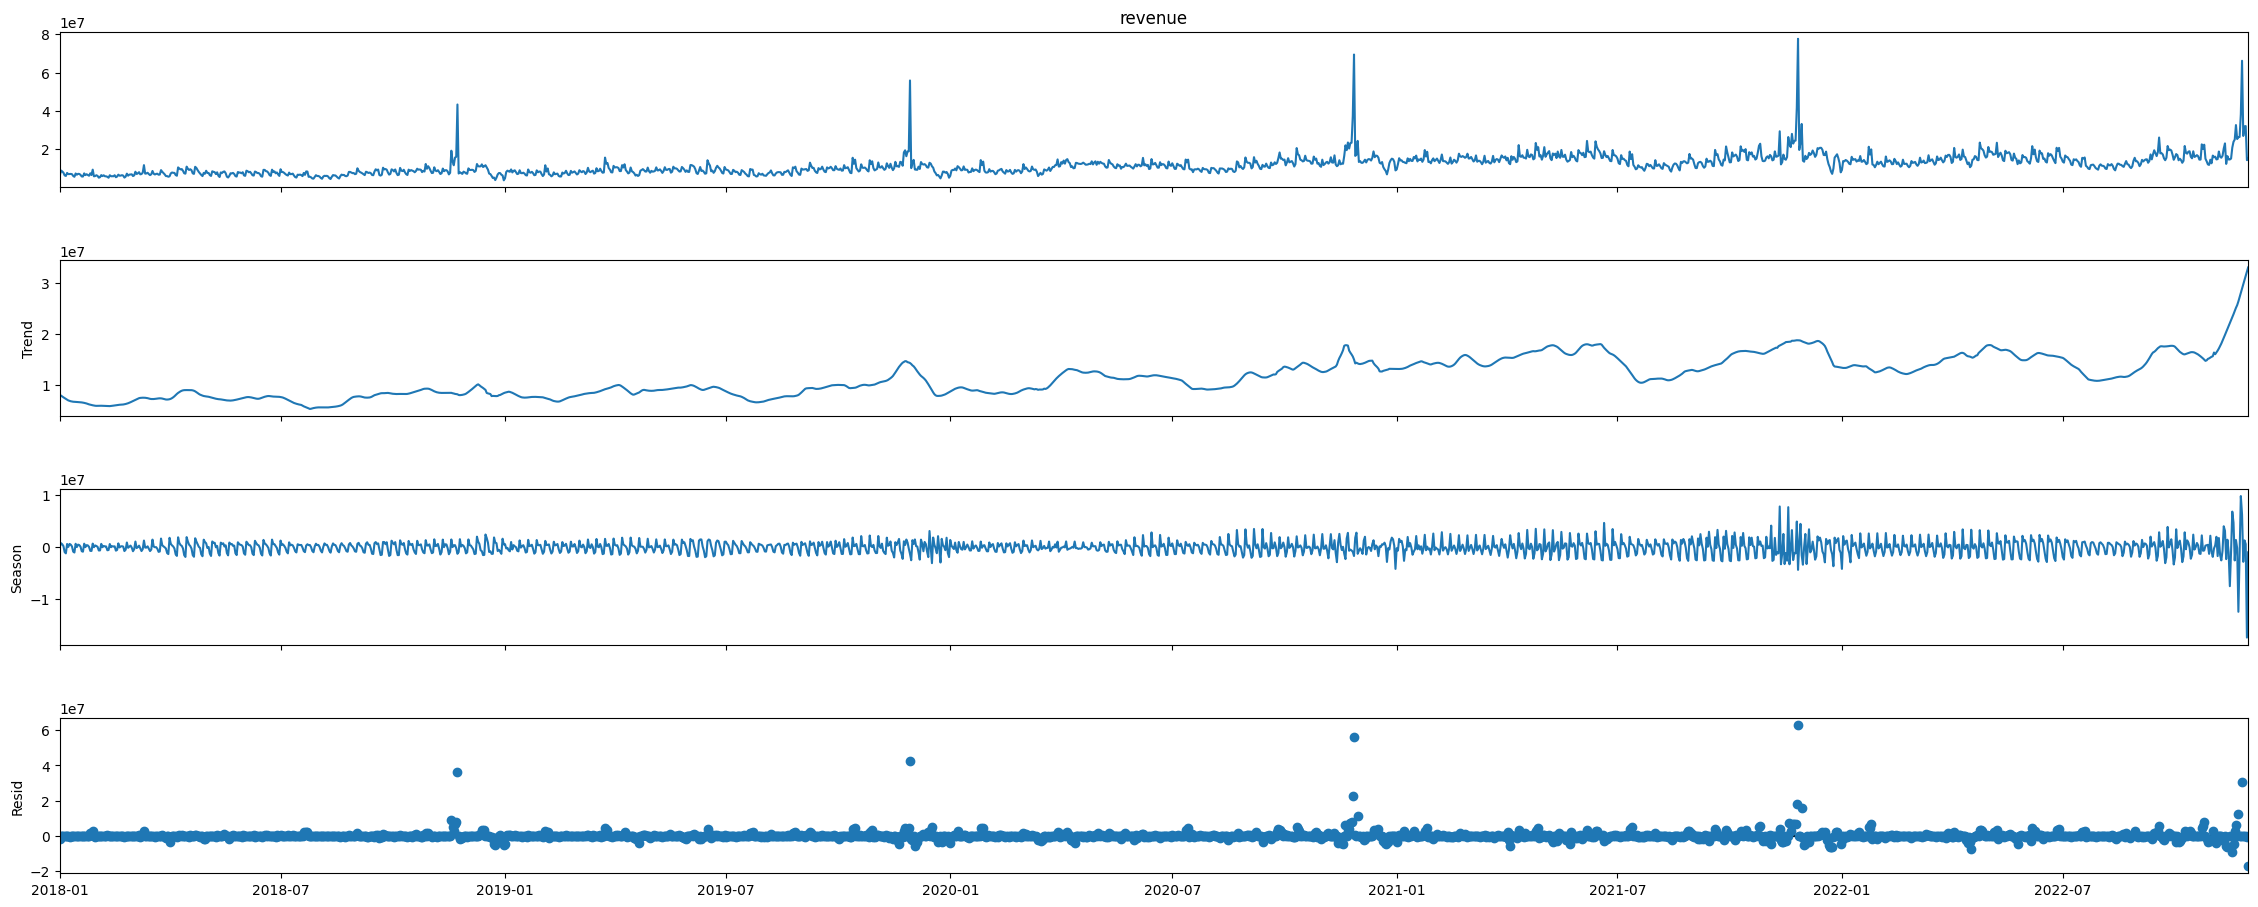

In [ ]:
# STL

from statsmodels.tsa.seasonal import STL

stl = STL(df['revenue'], robust = True)  # Robust = better handling of outliers
decomp_stl = stl.fit()

# Increase figure size
fig = decomp_stl.plot();
fig.set_size_inches(25, 10)  # Width = 12 inches, Height = 8 inches
plt.show()

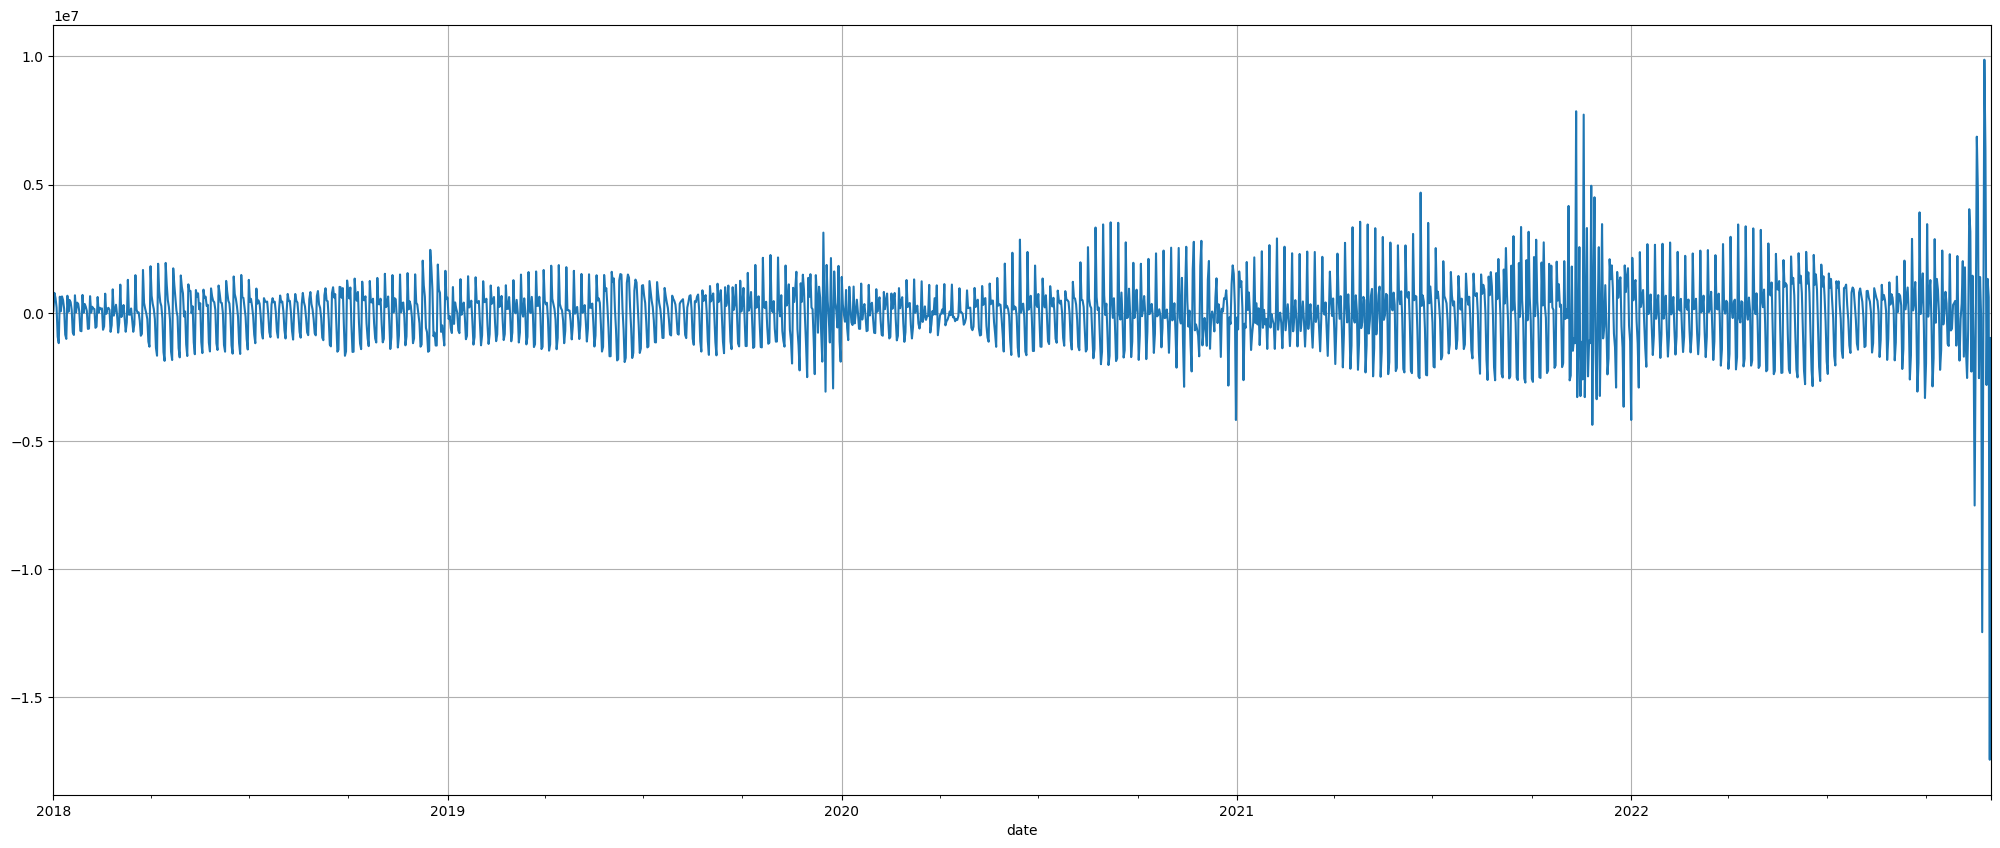

In [ ]:
# Trend, Seasonality, Residual

decomp_stl.seasonal.plot(figsize = (25,10))
plt.grid()
plt.show()

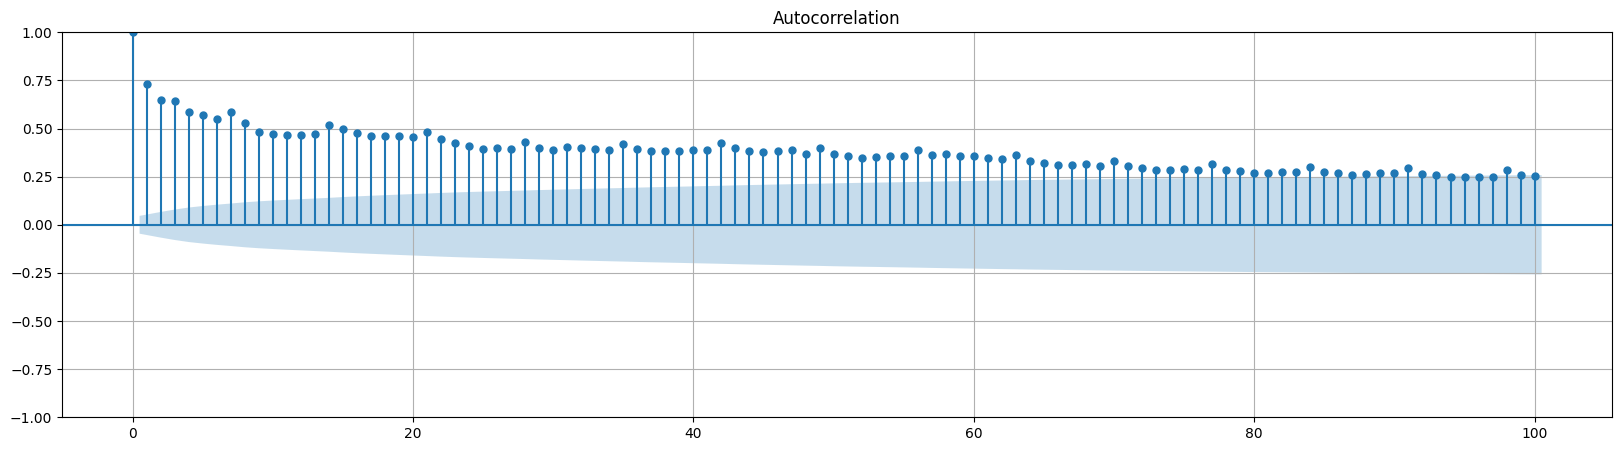

In [ ]:
# ACF

from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(20, 5))  # Create fig and ax explicitly
plot_acf(df['revenue'], lags = 100, title='Autocorrelation', ax=ax)
ax.grid(True)  # Optional: ensures grid is shown
plt.show()

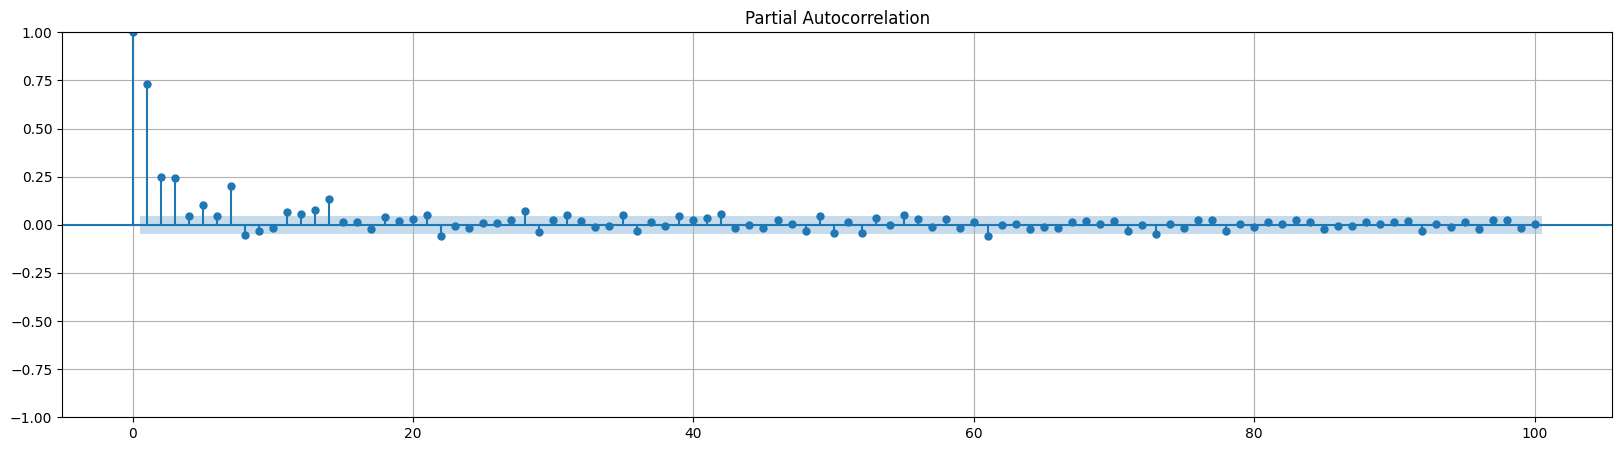

In [ ]:
# PACF

from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(20, 5))  # Create fig and ax explicitly
plot_pacf(df['revenue'], lags = 100, title='Partial Autocorrelation', ax=ax)
ax.grid(True)  # Optional: ensures grid is shown
plt.show()

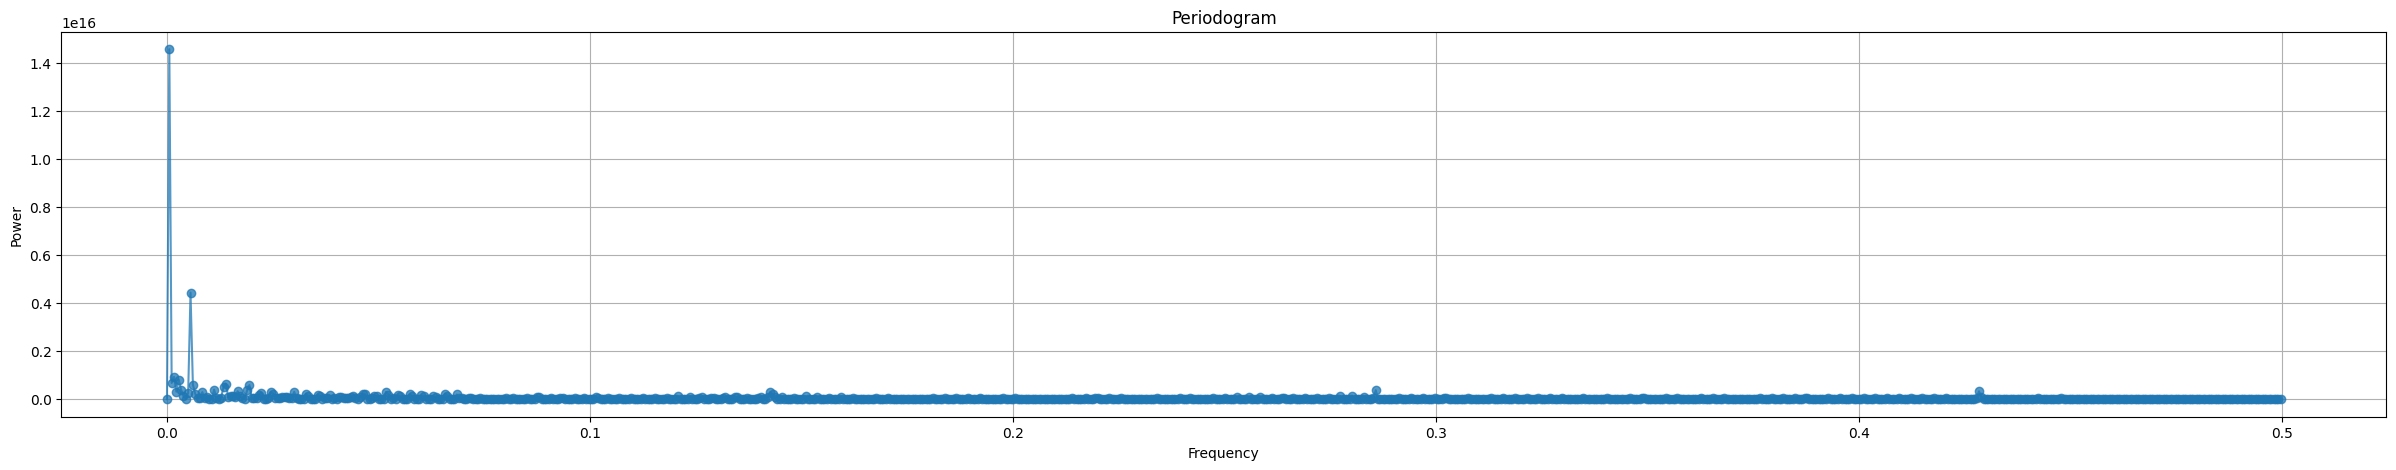

In [ ]:
# Periodogram (for Seasonality)

from scipy.signal import periodogram

# Compute the periodogram
frequencies, power = periodogram(df['revenue'])

# Plot the periodogram
plt.figure(figsize=(30, 5))
plt.plot(frequencies, power, marker='o', linestyle='-', alpha = 0.75)
plt.title("Periodogram")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid(True)
plt.show()

In [ ]:
# Test for Stationarity (>= 0.05 is Non-Stationary, < = 0.05 is Stationary)

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['revenue'])
print(result[1])

0.10190360862386094


In [ ]:
# Differencing

x = df['revenue'].diff().dropna()
x

,revenue
date,
2018-01-02,2651237.0
2018-01-03,-475975.0
2018-01-04,-660303.0
2018-01-05,-1410495.0
2018-01-06,-279885.0
...,...
2022-11-26,-39180777.0
2022-11-27,4955921.0
2022-11-28,210050.0


In [ ]:
# TS is now stationary

result = adfuller(x)
print(result[1])

6.513792026816299e-24


## SARIMAX Model

In [ ]:
# Split the data into training and test

test_days = 30

train, test = df.iloc[:-test_days, :], df.iloc[-test_days:, :]
exog_train, exog_test = df.iloc[:-test_days, 1:3], df.iloc[-test_days:, 1:3]

In [ ]:
# Quick Fix on pmdarima (Library incompatibilities since recent changes to numpy)

# !pip install pmdarima==2.0.4 -q
# !pip uninstall -y numpy
# !pip install --no-cache-dir --force-reinstall numpy==1.26.4

# import os
# os._exit(00)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.7 MB/s eta 0:00:00
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 174.9 MB/s eta 0:00:00


In [ ]:
# Libraries

from pmdarima import auto_arima

In [ ]:
# Model

model = auto_arima(train['revenue'], m = 7, X = exog_train) # m = seasonal_periods
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28613.022
Date:                           Fri, 04 Apr 2025   AIC                          57250.045
Time:                                   00:55:35   BIC                          57315.749
Sample:                               01-01-2018   HQIC                         57274.324
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      1.641e+04   7880.847      2.082      0.037     964.544    3.19e+04
discount_rate   4.03e+05   2.35e+04     17.146      0.000    3.57e+05    4.49e+05
coupon_rate    9.229e+05   6.09e+04     15.156      0.000    8.04e+05    1.04e+06
ar.L1            -0.6527      0.155     -4.198      0.000      -0.957      -0.348
ar.L2             0.1827      0.049      3.766      0.000       0.088       0.278
ma.L1             0.1067      0.155      0.690      0.490      -0.197       0.410
ma.L2            -0.6922      0.124     -5.567      0.000      -0.936      -0.449
ar.S.L7           0.0524      0.187      0.280      0.780      -0.315       0.419
ar.S.L14          0.8999      0.178      5.062      0.000       0.551       1.248
ma.S.L7           0.0182      0.183      0.099      0.921      -0.340       0.376
ma.S.L14         -0.8501      0.161     -5.286      0.000      -1.165      -0.535
sigma2         7.655e+12      0.016   4.82e+14      0.000    7.65e+12    7.65e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1075250.80
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                             5.53
Prob(H) (two-sided):                  0.00   Kurtosis:                       123.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.85e+29. Standard errors may be unstable.
"""

In [ ]:
# Stepwise Fitting

stepwise_fit = auto_arima(train['revenue'], seasonal = True, stepwise = True, trace = True, m = 7, X = exog_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=57566.715, Time=9.17 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=58227.547, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=57935.847, Time=0.71 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=57734.264, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=58225.549, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=57640.319, Time=2.75 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=57635.054, Time=2.33 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=57568.136, Time=15.65 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=57568.601, Time=14.07 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=57667.033, Time=3.85 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=57634.563, Time=7.33 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=57627.527, Time=6.88 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=11.94 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=57566.982, Time=3.22 sec
 ARIMA(2,1,1)(1,0,1)[7

In [ ]:
# Predictions

predictions_sarimax = model.predict(n_periods = len(test), X = exog_test)
predictions_sarimax

,0
2022-11-01,1.675203e+07
2022-11-02,1.494534e+07
2022-11-03,1.488390e+07
2022-11-04,1.296350e+07
2022-11-05,1.205396e+07
2022-11-06,1.394979e+07
2022-11-07,1.341718e+07
2022-11-08,1.328240e+07
2022-11-09,1.441167e+07
2022-11-10,2.077564e+07


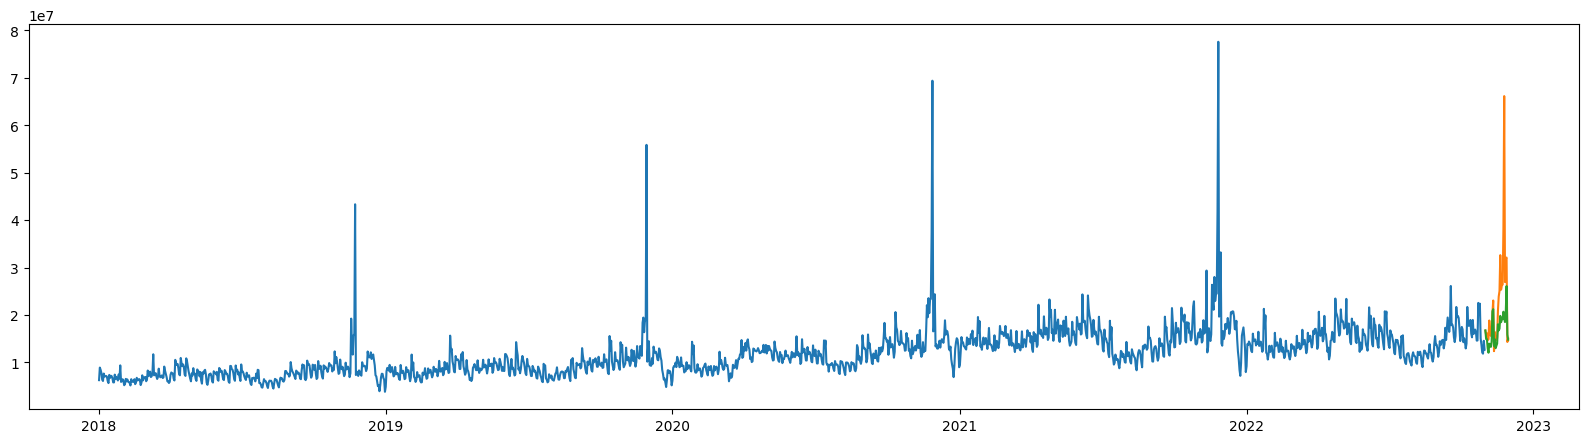

In [ ]:
# Test Set vs Train Forecast

plt.figure(figsize = (20, 5))
plt.plot(train.index, train['revenue'])
plt.plot(test.index, test['revenue'])
plt.plot(predictions_sarimax.index, predictions_sarimax)
plt.show()

In [ ]:
# Metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def forecast_metrics(test, predictions):

  print(f'MAE: {mean_absolute_error(test, predictions)}')
  print(f'MSE: {mean_squared_error(test, predictions)}')
  print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions))}')
  print(f'MAP: {mean_absolute_percentage_error(test, predictions) * 100}')

forecast_metrics(test['revenue'], predictions_sarimax)

MAE: 5716506.24322597
MSE: 108046732869228.39
RMSE: 10394553.038453765
MAP: 19.35995644708954


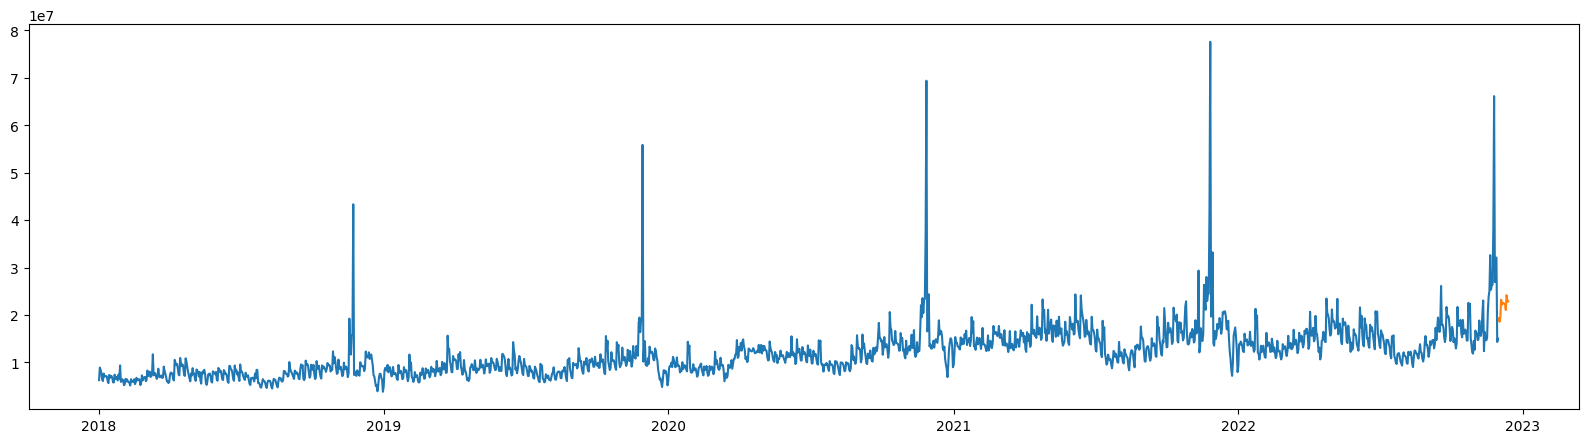

In [ ]:
# Forecast to the Future

from statsmodels.tsa.statespace.sarimax import SARIMAX

final_model = SARIMAX(df['revenue'], order = (3, 1, 2), seasonal_order = (2, 0, 2, 7), X = df[['discount_rate', 'coupon_rate']])
results = final_model.fit()
forecast = results.predict(start = len(df['revenue']), end = len(df['revenue']) + 12)

plt.figure(figsize = (20, 5))
plt.plot(df.index, df['revenue'])
plt.plot(forecast.index, forecast)
plt.show()